run for 10 years to get to steady state and then run the new drought conditions in this file and the new flood conditions in the sample topo flood file. 


In [2]:

# PYTHON IMPORTS
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel
import cv2 
from random import randint
import math

# LANDLAB COMPONENTS 
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
from landlab.components import PrecipitationDistribution

# SPACE COMPONENTS 
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

# LANDLAB UTILITIES 
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 
from landlab.utils.flow__distance import calculate_flow__distance

%matplotlib inline

In [3]:
# GRID SPECS
ncols = 100
nrows = 100
cellsize = 10

# RETRIEVE TOPO FROM ASCII
topo_dem = "sample_topo2_topographic__elevation.txt" #the name of the ascii file
topo_path = topo_dem
topo_header = read_asc_header(open(topo_path, 'r'))
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0) #generating the new grid

# FIND OUTLET
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()
min_topo_ID = open_nodes[min_topo]
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
outlet_id = min_topo_ID

# HYDROLOGICALLY FILL THE aDEM
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

# CLOSE BOUNDARIES
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)

# # PLOT THE TOPOGRAPHY 
# figelev = plt.figure()#Instantiate figure as empty plot
# plot = plt.subplot()#Instantiate subplot as empty plot
# imshow_grid(mg, 'topographic__elevation', plot_name='Sample Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
# fname = "final_plots/sample_INITIAL_TOPO.png"
# figelev.savefig(fname, dpi='figure', format=None)

# ADDING SOIL FIELD
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

# ADDING BEDROCK FIELD
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']

# SETTING UP OUTLET ID 
mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
print(outlet_id)

# ADDING SURFACE WATER DEPTH
mg.add_zeros('surface_water__depth', at='node')

# ADDING SURFACE WATER DISCHARGE
mg["node"]["surface_water__discharge"] = np.zeros(mg.number_of_nodes)


101


retrieving the topography from ascii

ncols = 932
nrows = 891
cellsize = 9.0321982288432

#mg = RasterModelGrid()
#Set directory paths to retrieve the asc file
path_project = r"../" # add the path to the asc file    #this should access my H drive
topo_dem = "alex_ascii.txt" #the name of the ascii file
#soil_dem = "sample_topo2_soil__depth.txt"
#bedrock_dem = "sample_topo2_bedrock__elevation.txt"
topo_path = path_project + topo_dem
#soil_path = path_project + soil_dem
#bedrock_path = path_project + bedrock_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
topo_header = read_asc_header(open(topo_path, 'r'))
#soil_header = read_asc_header(open(soil_path, 'r'))
#bedrock_header = read_asc_header(open(bedrock_path, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0)
#(mg, x) = read_esri_ascii(soil_path, name= 'soil__depth', halo = 1)
#(mg, y) = read_esri_ascii(bedrock_path, name= 'bedrock__elevation', halo = 1)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)#Close all model boundary edges


#find min elevation
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()

min_topo_ID = open_nodes[min_topo]

print(min_topo_ID)


#outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999.)
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id
outlet_id = min_topo_ID
#print(mg.at_node.keys()) #Shows the node attributes

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
#mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#Instantiate figure as empty plot



# ADDING SOIL FIELD
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

# ADDING BEDROCK FIELD
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']

# SETTING UP OUTLET ID 
mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
print(outlet_id)

# ADDING SURFACE WATER DEPTH
mg.add_zeros('surface_water__depth', at='node')

# ADDING SURFACE WATER DISCHARGE
mg["node"]["surface_water__discharge"] = np.zeros(mg.number_of_nodes)


figelev = plt.figure()

#Instantiate subplot as empty plot
#plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


In [4]:
print(mg.fields())

{'at_node:topographic__elevation', 'at_node:sediment_fill__depth', 'at_node:surface_water__depth', 'at_node:bedrock__elevation', 'at_node:soil__depth', 'at_node:surface_water__discharge'}


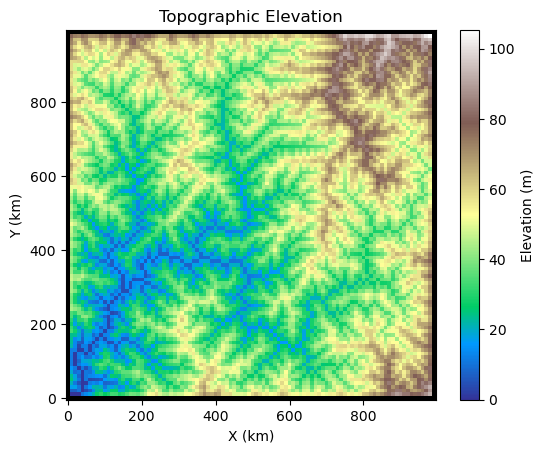

In [5]:
# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
plot = plt.subplot()#Instantiate subplot as empty plot


imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('km', 'km'), cmap='terrain',color_for_background=None)

In [6]:
# PARAMETERS FOR SPACE
K_sed = 0.0001# Lists for saving data01 # ADDED A 0 HERE 4/11
K_sp = 0.001
K_br = 0.0000001
F_f = 0.5
phi = 0.1 #MADE THIS 1 INSTEAD OF 0 4/11
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0.5
sp_crit_br = 1.0

# SET MODEL TIME PARAM
sp_timestep = 1/365
#run_time = 100 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * sp_timestep
soil_rate = .00000000002739 #m/year
soil_per_per_timestep = .001*sp_timestep #0.00000273973 #1mm/year into m/hr


#INSTANTIATING COMPONENTS 
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

fa = FlowAccumulator(mg, flow_director='D8') 

df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)

sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br,discharge_field='surface_water__discharge')# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br 
#Instantiate SPACE model with chosen parameters as sp
# sp = SpaceLargeScaleEroder(grid=mg, K_sed= K_sed, K_br=K_br, F_f=F_f, phi=phi, H_star=H_star, v_s=v_s, m_sp=m_sp,  n_sp=n_sp, sp_crit_sed=sp_crit_sed, sp_crit_br=sp_crit_br, discharge_field='surface_water__discharge')# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br 

expweath = ExponentialWeatherer(mg)

DDdiff = DepthDependentDiffuser(mg, soil_transport_decay_depth=1)

expweath.calc_soil_prod_rate()

np.allclose(mg.at_node['soil_production__rate'][mg.core_nodes], .0001)

# RUNNING FSC FOR 1 YEAR TO IDENTIFY CHANNELS 
#fa.run_one_step()
#df.map_depressions()
#fsc.run_one_step(1)




# SET UP CHANNEL PROFILER AND RUN 
#profiler = ChannelProfiler(mg,number_of_watersheds=1,minimum_channel_threshold=0,main_channel_only=True)
#profiler.run_one_step()
#profiler.data_structure.keys() #is [101]
#profiler.data_structure[1452].keys()
#profiler.data_structure[1452][(1452,9687)]["ids"] #produces array of id values for the channel

False

CHANGE VISUALS SETTING UP

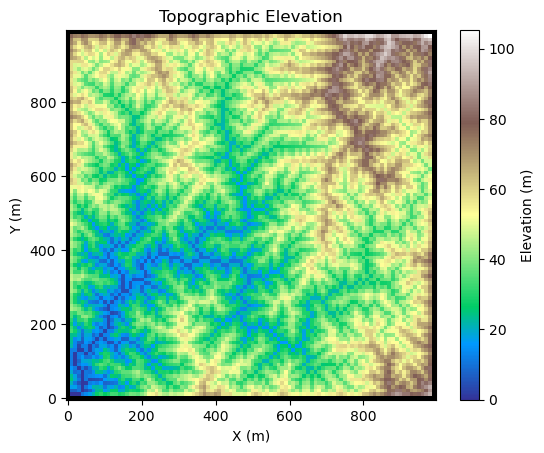

In [7]:
# PLOT THE TOPOGRAPHY 
figelev = plt.figure()#Instantiate figure as empty plot
#plot = plt.subplot()#Instantiate subplot as empty plot

imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

In [8]:
# SETTING UP OLD TOPO
mg.add_zeros('node', 'old__topo')



mg.add_zeros('node','change__topo')
mg.add_zeros('node', 'change__water')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [9]:
# VARIABLES FOR OVERLAND FLOW AND PRECIP

## OVERALL
model_total_years = 1 # (yrs)
rain_total_t =15 #8760 *1#(hrs) 3 make this for spring season actually 
model_total_t = 8760 * model_total_years #(hrs)
model_total_days = model_total_years*365

## WINTER --- 91.25 days = 2190 hrs each season
winter_stm_avg_dur = 24
winter_interstm_avg_dur = 672
winter_stm_avg_int= .02

## SPRING
spring_stm_avg_dur = 24
spring_interstm_avg_dur = 672
spring_stm_avg_int = .02

## SUMMER
summer_stm_avg_dur = 24
summer_interstm_avg_dur = 672
summer_stm_avg_int= .02
## FALL 
fall_stm_avg_dur = 24
fall_interstm_avg_dur = 672
fall_stm_avg_int= .02



In [10]:
# INITIALIZE RAIN COMPONENTS 
of = OverlandFlow(mg, steep_slopes=True)
rain = PrecipitationDistribution(mg,mean_storm_duration=spring_stm_avg_dur, mean_interstorm_duration=spring_interstm_avg_dur,mean_storm_depth=spring_stm_avg_int, total_t=rain_total_t, delta_t=1.0)

# ARRAYS FOR STORING DATA
storm_time_data = []
interstorm_time_data = []
storm_amt_data = []
hydrograph_time = []

discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []

# GETTING THE NODES FOR THE HYDROGRAPH
outlet_node_to_sample = 404
outlet_link_to_sample = mg.links_at_node[outlet_node_to_sample][3]
upstream_node_to_sample = 1102
upstream_link_to_sample = mg.links_at_node[upstream_node_to_sample][3]
midstream_node_to_sample = 1709
midstream_link_to_sample = mg.links_at_node[midstream_node_to_sample][3]




In [11]:
# LOOP ITERATION VARIABLES
model_elapsed_time = 0 
# LOOP ITERATION VARIABLES
model_elapsed_time = 0 
model_elapsed_years = 0
model_total_years = 10
model_time = 0

model_elapsed_days = 0 

# SEASONONAL LOOPING
winter_t_hrs = 91 * 24
winter_elapsed_hrs = 0

spring_t_hrs = 91 * 24
spring_elapsed_hrs = 0

summer_t_hrs = 91 * 24
summer_elapsed_hrs =0

fall_t_hrs=91 * 24
fall_elapsed_hrs = 0

## RUN THE MODEL
while model_elapsed_years < model_total_years:#over the years
    for x in range(1,5):
        if x ==1:#it is winter
            stm_avg_dur = winter_stm_avg_dur
            interstm_avg_dur = winter_interstm_avg_dur
            stm_avg_int = winter_stm_avg_int
            t_hrs = winter_t_hrs
            elapsed_hrs = 0
            model_hrs = winter_t_hrs
            print("---------IN WINTER-------Year "+str(model_elapsed_years)+"------------")
        
        elif x ==2: #it is spring 
            stm_avg_dur = spring_stm_avg_dur
            interstm_avg_dur = spring_interstm_avg_dur
            stm_avg_int = spring_stm_avg_int
            t_hrs = spring_t_hrs
            print("---------IN SPRING-------Year "+str(model_elapsed_years)+"------------")
            
        elif x ==3:
            stm_avg_dur = summer_stm_avg_dur
            interstm_avg_dur = summer_interstm_avg_dur
            stm_avg_int = summer_stm_avg_int
            t_hrs = summer_t_hrs
            print("---------IN SUMMER-------Year "+str(model_elapsed_years)+"------------")
            
        elif x == 4:
            stm_avg_dur = fall_stm_avg_dur
            interstm_avg_dur = fall_interstm_avg_dur
            stm_avg_int = fall_stm_avg_int
            t_hrs = fall_t_hrs
            print("---------IN FALL-------Year "+str(model_elapsed_years)+"------------")
          
        if model_elapsed_years == 1:
            mg.at_node["old__topo"][:] = mg.at_node["topographic__elevation"] 
 
        # INITIALIZE COMPONENTS FOR THE SEASON
        mg.delete_field(loc='grid',name= 'rainfall__flux')
        rain = PrecipitationDistribution(mg,mean_storm_duration=stm_avg_dur, mean_interstorm_duration=interstm_avg_dur,mean_storm_depth=stm_avg_int, total_t=t_hrs,delta_t=1.0)
        of = OverlandFlow(mg, steep_slopes=True)

        # ARRAYS FOR STORING DATA
        stm_dur=[]
        interstm_dur=[]
        num_stm = 0
        int_pattern=[]

        ## GET STORM INFO FIRST
        first = False
        second = False
        rain.seed_generator(seedval=10)
        for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
            
            for x in range(int(storm_t)):
                int_pattern.append(mg.at_grid['rainfall__flux']) #add intensity for duration of the storm
                
            #print(rain.elapsed_time)
            
            for x in range(int(interstorm_t)):
                int_pattern.append(int(0.0)) #eno intensity during interstorm period
        
            stm_dur.append(storm_t)
            interstm_dur.append(interstorm_t)
            num_stm+=1
            storm_amt_data.append(num_stm)
        if x ==1:
            first_stm_hydro_t = stm_dur[0] + interstm_dur[0]
            print(first_stm_hydro_t)
            print("length of int_pattern " + str(len(int_pattern)))
            
        elapsed_hrs = 0
        while elapsed_hrs <= len(int_pattern):
            of.dt = of.calc_time_step()
            mg.at_node['bedrock__elevation'][mg.core_nodes] += (uplift_rate*(1/8760)*of.dt)  #adding uplift to the bedrock
            mg.at_node['bedrock__elevation'][mg.core_nodes] -= (soil_rate*(1/8760)*of.dt)#adding uplift to the bedrock
            mg.at_node['soil__depth'][mg.core_nodes] += (soil_rate*(1/8760)*of.dt)#adding uplift to the bedrock
            mg.at_node['topographic__elevation'][mg.core_nodes]+= uplift_rate*(1/8760)*of.dt  #adding uplift to the bedrock

            DDdiff.run_one_step((1/8760)*of.dt)
            of.rainfall_intensity = int_pattern[int(elapsed_hrs)]#*(1.15741*10**-8)
            of.run_one_step(dt=of.dt)
            
            elapsed_hrs += of.dt
            #print(of.rainfall_intensity)
            
            if x == 1 and elapsed_hrs <= first_stm_hydro_t:
                hydrograph_time.append(model_elapsed_time)
                q = mg.at_link["surface_water__discharge"]
                discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * mg.dx)
                discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * mg.dx)
                discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * mg.dx)
                        
            #print("timestep =" + str(of.dt))
            # print("elapsed time = " + str(elapsed_hrs))
            #print("length of int_pattern " + str(len(int_pattern)))
        # sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br,discharge_field='rainfall__flux')# K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br 
        fr.run_one_step()
        sp.run_one_step(dt = 0.25)
        elapsed_hrs = 0
    if model_elapsed_years ==1:#save current topo as old topo
        mg.at_node["old__topo"][:] = mg.at_node["topographic__elevation"] 
    if model_elapsed_years > 1:
        mg.at_node["change__topo"][:] = (mg.at_node["topographic__elevation"] - mg.at_node['old__topo'])
        mg.at_node['change__topo'][outlet_id] = mg.at_node['change__topo'][outlet_id+1]
        
         
        # PLOT THE TOPOGRAPHY CHANGE & save
        figelev = plt.figure()#Instantiate figure as empty plot
        plot = plt.subplot()#Instantiate subplot as empty plot
        imshow_grid(mg,'change__topo', plot_name='Change In Topographic Elevation After' +str(model_elapsed_years) +'Years', var_name = 'Elevation Change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        fname = "drought_imgs/drought_topo_change_"+ str(model_elapsed_years) +"_yrs"+".png"
        figelev.savefig(fname, dpi='figure', format=None)
        plt.close(figelev)
            
        figelev = plt.figure()#Instantiate figure as empty plot
        plot = plt.subplot()#Instantiate subplot as empty plot
        imshow_grid(mg,'topographic__elevation', plot_name='Topographic Elevation After' +str(model_elapsed_years) +'Years', var_name = 'Elevation Change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        fname = "drought_imgs/drought__topo_"+ str(model_elapsed_years) +"_yrs"+".png"
        figelev.savefig(fname, dpi='figure', format=None)
        plt.close(figelev)

        figelev = plt.figure()#Instantiate figure as empty plot
        plot = plt.subplot()#Instantiate subplot as empty plot
        imshow_grid(mg,'sediment__flux', plot_name='Sediment Flux After' +str(model_elapsed_years) +'Years', var_name = 'Sediment Flux ($m^3$)', var_units=r'', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
        fname = "drought_imgs/drought__sedFlux_"+ str(model_elapsed_years) +"_yrs"+".png"
        figelev.savefig(fname, dpi='figure', format=None)
        plt.close(figelev)

    model_elapsed_years +=1

# mg.at_node["change__topo"][:] = (mg.at_node["topographic__elevation"] - mg.at_node['old__topo'])
# mg.at_node['change__topo'][outlet_id] = mg.at_node['change__topo'][outlet_id+1]
#mg.at_node["topographic__elevation"] = mg.at_node['old__topo']+mg.at_node["change__topo"]

#mg.at_node['sediment__flux'][:] = mg.at_node['sediment__flux']
#mg.at_node['sediment__flux'][outlet_id] = mg.at_node['sediment__flux'][outlet_id+1]

# PLOT THE TOPOGRAPHY CHANGE & save
# figelev = plt.figure()#Instantiate figure as empty plot
# plot = plt.subplot()#Instantiate subplot as empty plot
# imshow_grid(mg,'change__topo', plot_name='Change In Topographic Elevation After 100 Years', var_name = 'Elevation Change', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
# fname = "final_plots/alex_drought_topoChange_"+ str(model_total_years) +"_yrs"+".png"
# figelev.savefig(fname, dpi='figure', format=None)
       
# # PLOT THE drainage area CHANGE & save
# figelev = plt.figure()#Instantiate figure as empty plot
# plot = plt.subplot()#Instantiate subplot as empty plot
# imshow_grid(mg,'sediment__flux', plot_name='Sediment Flux After 100 Years', var_name = 'Sediment Flux ($m^3$)', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
# fname = "final_plots/alex_drought_sedFlux_"+ str(model_total_years) +"_yrs"+".png"
# figelev.savefig(fname, dpi='figure', format=None)



---------IN WINTER-------Year 0------------


KeyboardInterrupt: 

In [ ]:
#print(mg.at_node[0].)

print(mg.fields())

{'at_node:flow__link_to_receiver_node', 'at_node:surface_water__discharge', 'at_link:water_surface__gradient', 'at_node:topographic__elevation', 'at_node:topographic__steepest_slope', 'at_node:change__water', 'at_node:is_pit', 'at_grid:rainfall__flux', 'at_node:bedrock__elevation', 'at_link:surface_water__discharge', 'at_link:surface_water__depth', 'at_node:flow__sink_flag', 'at_node:sediment__flux', 'at_node:sediment__influx', 'at_node:old__topo', 'at_node:water__unit_flux_in', 'at_node:drainage_area', 'at_node:surface_water__depth', 'at_node:depression__depth', 'at_node:flow__upstream_node_order', 'at_node:sediment_fill__depth', 'at_node:squared_length_adjacent', 'at_node:flow__data_structure_delta', 'at_node:soil__depth', 'at_node:depression__outlet_node', 'at_node:flood_status_code', 'at_link:soil__flux', 'at_node:soil_production__rate', 'at_node:flow__receiver_proportions', 'at_node:change__topo', 'at_node:sediment__outflux', 'at_link:topographic__slope', 'at_node:depression_free_

In [12]:
outlet_node_to_sample = 604
outlet_link_to_sample = mg.links_at_node[outlet_node_to_sample][3]
upstream_node_to_sample = 1202
upstream_link_to_sample = mg.links_at_node[upstream_node_to_sample][3]
midstream_node_to_sample = 3017
midstream_link_to_sample = mg.links_at_node[midstream_node_to_sample][3]


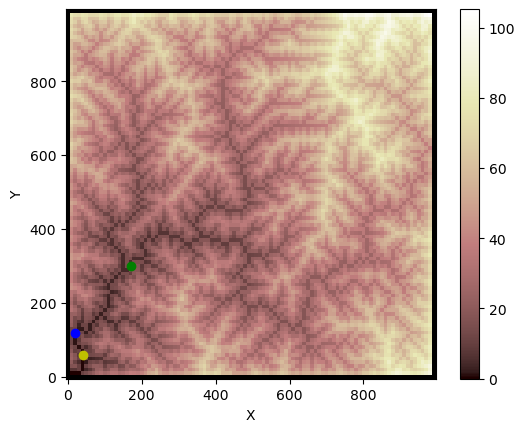

In [13]:
plt.figure(1)
imshow_grid(mg, z)  # plot the DEM
plt.plot(mg.node_x[outlet_node_to_sample], mg.node_y[outlet_node_to_sample], "yo")
plt.plot(mg.node_x[upstream_node_to_sample], mg.node_y[upstream_node_to_sample], "bo")
plt.plot(mg.node_x[midstream_node_to_sample], mg.node_y[midstream_node_to_sample], "go")

In [14]:
#variables for hurricane
hurricane_depth = 0.127 #(m) over 24 hrs 

hurricane_dur= 86400 #(s)
starting_precip = hurricane_depth / (hurricane_dur) #(m) is a 10 year storm depth for 24 hr span

hurricane_total_t = 86400*20000 #2 days (s)
hurricane_elapsed_t=0
## Lists for saving data
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []


In [15]:
while hurricane_elapsed_t < hurricane_total_t:
    # Setting the adaptive time step
    of.dt = of.calc_time_step()

    ## The storm starts when the model starts. While the elapsed time is less
    ## than the storm duration, we add water to the system as rainfall.
    if hurricane_elapsed_t < (hurricane_dur):
        of.rainfall_intensity = starting_precip
    else:  # elapsed time exceeds the storm duration, rainfall ceases.
        of.rainfall_intensity = 0.0

    of.run_one_step()  # Generating overland flow based on the deAlmeida solution.

    ## Append time and discharge to their lists to save data and for plotting.
    hydrograph_time.append(hurricane_elapsed_t)
    q = mg.at_link["surface_water__discharge"]
    discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * mg.dx)
    discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * mg.dx)
    discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * mg.dx)

    ## output time every now and then so that you know the code
    ## is actually running
    if (hurricane_elapsed_t % 1000) < 2:
        print("elapsed time = ", hurricane_elapsed_t)

    ## Updating elapsed_time
    hurricane_elapsed_t += of.dt

elapsed time =  0
elapsed time =  0.718382052997
elapsed time =  1.43676573198
elapsed time =  1000.48032427
elapsed time =  1001.19921832
elapsed time =  1001.91811246
elapsed time =  2000.51856545
elapsed time =  2001.2375244
elapsed time =  2001.95648337
elapsed time =  3000.60347572
elapsed time =  3001.32244974
elapsed time =  4000.69914521
elapsed time =  4001.41812245
elapsed time =  5000.07807724
elapsed time =  5000.79705513
elapsed time =  5001.51603301
elapsed time =  6000.17643124
elapsed time =  6000.89540926
elapsed time =  6001.61438727
elapsed time =  7000.27487248
elapsed time =  7000.99385052
elapsed time =  7001.71282856
elapsed time =  8000.37333109
elapsed time =  8001.09230914
elapsed time =  8001.81128718
elapsed time =  9000.47179325
elapsed time =  9001.19077129
elapsed time =  9001.90974934
elapsed time =  10000.5702561
elapsed time =  10001.2892342
elapsed time =  11000.6687192
elapsed time =  11001.3876972


KeyboardInterrupt: 

(0.0, 1300.0, 0.0, 0.0080000000000000002)

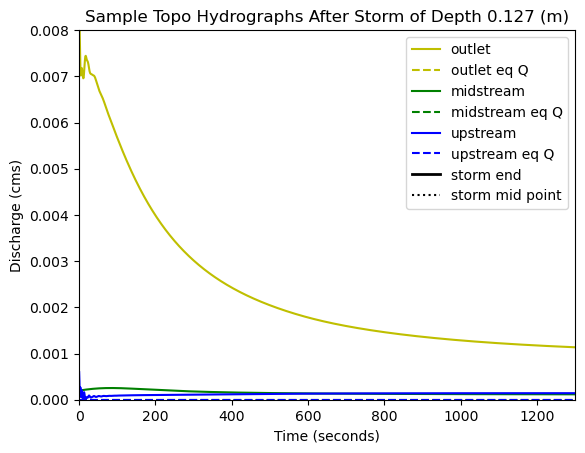

In [22]:

## Calculate equilibrium discharge at each point for reference
outlet_eq_q = (starting_precip* mg.at_node["drainage_area"][outlet_node_to_sample])
midstream_eq_q = (starting_precip* mg.at_node["drainage_area"][midstream_node_to_sample])
upstream_eq_q = (starting_precip * mg.at_node["drainage_area"][upstream_node_to_sample])

#plt.figure(1)

## Plotting hydrographs and equilibrium discharge
plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "y-", label="outlet")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [outlet_eq_q, outlet_eq_q],
    "y--",
    label="outlet eq Q",
)
plt.plot(hydrograph_time, discharge_midstream, "g-", label="midstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [midstream_eq_q, midstream_eq_q],
    "g--",
    label="midstream eq Q",
)
plt.plot(hydrograph_time, discharge_upstream, "b-", label="upstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [upstream_eq_q, upstream_eq_q],
    "b--",
    label="upstream eq Q",
)

## Plot storm end and center of storm for reference
plt.plot(
    [hurricane_dur, hurricane_dur], [0, 100], "k-", linewidth=2, label="storm end"
)
plt.plot(
    [hurricane_dur / 2, hurricane_dur / 2], [0, 100], "k:", label="storm mid point"
)

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
title_text = "Sample Topo Hydrographs After Storm of Depth " + str(hurricane_depth) +" (m)"
plt.title(title_text)
#plt.axis([0, np.max(hydrograph_time), 0, .0100])
plt.axis([0, 1300, 0, .008])

## PLOT EQUILIBRIUM DISCHARGE LINES
#plt.axhline(y=outlet_eq_q, color='y', linestyle='--')
#plt.axhline(y=midstream_eq_q, color='g', linestyle='--')
#plt.axhline(y=upstream_eq_q, color='b', linestyle='--')

# ## NOW PLOT HYDROGRAPH LINES
# plt.plot(hydrograph_time, discharge_at_outlet,"y-")
# plt.plot(hydrograph_time, discharge_midstream,"g-")
# plt.plot(hydrograph_time, discharge_upstream,"b-")

# ## Plot storm end and center of storm for reference
# #plt.plot([spring_stm_avg_dur, spring_stm_avg_dur], [0, 100], "k-", linewidth=2, label="storm end")
# #plt.plot([spring_stm_avg_dur / 2, spring_stm_avg_dur / 2], [0, 100], "k:", label="storm mid point")

# plt.ylabel("Discharge (mm/hr)")
# plt.xlabel("Time (hours)")
# plt.legend(loc="upper right")
# title_text = "Hydrographs" 
# plt.title(title_text)
#plt.axis([0, np.max(hydrograph_time), 0, np.max(hydrograph_time)])
#print(discharge_at_outlet)
#print(discharge_midstream)
#print(discharge_upstream)